In [88]:
import pickle
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
import json
import matplotlib.pyplot as plt
from userfunctions import *

In [3]:
# to communicate with google spreadsheet...
import gspread
from gspread_dataframe import get_as_dataframe
from gspread_dataframe import set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

s = sddk.cloudSession("sciencedata.dk")
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
mops_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1VbCIAJssHKV9hlRTwzVFfm40CGnHesq53KXjv2qy4OM/edit?usp=sharing")

endpoint variable has been configured to: https://sciencedata.dk/files/


In [78]:
import multiprocessing
multiprocessing.cpu_count()

8

In [83]:
jstor_df = pd.read_feather("../data/large_files/jstor_df_v1.feather")

In [84]:
len(jstor_df)

14103

In [7]:
jstor_df.head(5)

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,...,sequence,tdmCategory,title,url,volumeNumber,wordCount,docSubType,sourceCategory,subTitle,hasPartTitle
0,[],1959-10-01,article,10.1177/001452465907100107,ark://27927/phx66812gq6,"[{'name': 'doi', 'value': '10.1177/00145246590...",Expository Times,1,"[omnipotent reigneth, god omnipotent, silence,...",[eng],...,7.0,"[Religion - Theology, Religion - Spiritual bel...",In the Study,http://doi.org/10.1177/001452465907100107,71,7382,None,None,None,None
1,[Victor Paul Furnish],2009-01-01,chapter,10.1017/CBO9780511621321.003,ark://27927/pbd6fpf5fh,"[{'name': 'isbn', 'value': '9780511621321'}, {...",Jesus According to PaulJesus According to Paul,None,"[saying, books online, jesus tradition, pauls ...",[eng],...,5.0,"[History - Historical methodology, Religion - ...",3 Sayings of Jesus in Paul's Letters,https://doi.org/10.1017/CBO9780511621321.003,None,8577,None,None,None,None
2,[Leander E. Keck],2015-01-01,chapter,None,ark://27927/phw1kd8s300,[],Christ&#39;s First Theologian,None,"[pharisaism, sandmel genius, judaism, rabbinic...",[eng],...,8.0,"[History - Historical methodology, Religion - ...",3. The Quest for Pauls Pharisaism,None,None,5354,None,None,None,None
3,[LeAnn Snow Flesher],2009-02-01,article,10.1177/003463730910600105,ark://27927/phx64fptrwj,"[{'name': 'doi', 'value': '10.1177/00346373091...",Review & Expositor: An International Baptist J...,1,"[scofield, premillennial, premillennial dispen...",[eng],...,5.0,"[Religion - Theology, Religion - Spiritual bel...",The Historical Development of Premillennial Di...,http://doi.org/10.1177/003463730910600105,106,3614,None,None,None,None
4,[A. Daunton-Fear],1995-07-01,article,10.1177/0040571X9509800404,ark://27927/phx64k1x5c2,"[{'name': 'doi', 'value': '10.1177/0040571X950...",Theology,784,"[baptism, holy spirit, communion, infant bapti...",[eng],...,4.0,[Religion - Spiritual belief systems],Resisting the Tide Christian Initiation and Co...,http://doi.org/10.1177/0040571X9509800404,98,4323,None,None,None,None


In [8]:
# in english only?
jstor_df["language"].apply(lambda x: ("eng" in x) & (len(x)==1)).sum()

14096

In [9]:
article_ids_dict = pickle.load(open("../data/article_ids_dict.pickle", "rb"))

In [10]:
dictionary = pickle.load(open("../data/dictionary_main.pickle", "rb"))
len(dictionary)

41385

In [11]:
class FriendlyCorpus:
    def __iter__(self):
        for id in ids:
            short_id_str = str(article_ids_dict[id])
            id_filepath = "../data/large_files/article_docs/{}.pickle".format(short_id_str)
            for doc in pickle.load(open(id_filepath, "rb")):
                yield doc

In [12]:
ids = jstor_df["id"].tolist()
corpus = FriendlyCorpus()  # doesn't load the corpus into memory!
print(corpus)

In [13]:
type(corpus)

__main__.FriendlyCorpus

In [15]:
dct_corpus = Dictionary.from_corpus(corpus, id2word=dictionary)

In [16]:
nt_id = dct_corpus.token2id["New_Testament"]
nt_id

9235

In [17]:
dct_corpus.dfs[nt_id]

51371

In [18]:
vocabulary = list(dct_corpus.values())

In [19]:
len(dct_corpus)

41385

In [20]:
dct_corpus.token2id["Paul"]

9932

In [21]:
dct_corpus.doc2bow(["Paul", "New_Testament", "Old_Testament"])

[(9235, 1), (9603, 1), (9932, 1)]

In [22]:
ntopics = 5

In [28]:
%%time
#lda = LdaMulticore(corpus, num_topics=ntopics, id2word=dct_corpus)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [89]:
#lda.save("../data/large_files/lda_global_v1")

In [26]:
lda = LdaModel.load("../data/large_files/lda_global_v1")

In [27]:
lda.show_topic(0)

[('early', 0.014643986),
 ('work', 0.013115274),
 ('biblical', 0.012963274),
 ('text', 0.012277658),
 ('divine', 0.011409644),
 ('spiritual', 0.009946071),
 ('faith', 0.009898072),
 ('social', 0.009851946),
 ('Christians', 0.009469147),
 ('order', 0.008436895)]

In [60]:
ntopics = 5
topic_words_joined = []
for n in range(ntopics):
    topic_words_joined.append(", ".join([tup[0] for tup in lda.show_topic(n, topn=10)]))
topic_words_joined

['early, work, biblical, text, divine, spiritual, faith, social, Christians, order',
 'Christian, Jesus, church, Christ, new, Paul, way, theology, tradition, theological',
 'God, great, history, historical, Paul, religious, love, Israel, power, letter',
 'Jewish, human, world, good, use, second, century, death, study, Paul',
 'life, John, man, like, time, people, Roman, Paul, law, point']

In [49]:
for word in ["Christ", "Jesus", "Paul", "New_Testament", "Old_Testament", "Romans", "Corinthians", "Galatians", "law", "Jewish", "Jews", "Judea"]:
    print(word, lda.get_term_topics(dct_corpus.token2id[word], minimum_probability=0))

Christ [(1, 0.025210822)]
Jesus [(1, 0.031531658)]
Paul [(0, 0.006974078), (1, 0.011069962), (2, 0.0088760415), (3, 0.007267367), (4, 0.007393098)]
New_Testament [(0, 0.00074381643), (1, 0.0008302843), (2, 0.00048067883), (3, 0.0008008713), (4, 0.00057056826)]
Old_Testament [(1, 0.0014251649)]
Romans [(1, 0.0023071175), (3, 0.0066799927)]
Corinthians [(0, 0.0007317764), (1, 0.0011300398), (2, 0.00075825327), (3, 0.0008429485), (4, 0.0007668329)]
Galatians [(1, 0.0041462937)]
law [(4, 0.007385621)]
Jewish [(3, 0.017416224)]
Jews [(0, 0.0013330865), (1, 0.003820091), (4, 0.0013761432)]
Judea [(2, 0.00031325355)]


In [50]:
jstor_df.groupby("isPartOf").size().sort_values(ascending=False)

isPartOf
Religious Studies Review                                544
Journal of Biblical Literature                          442
The Catholic Biblical Quarterly                         332
Expository Times                                        330
Review & Expositor: An International Baptist Journal    265
                                                       ... 
Kenyan, Christian, Queer                                  1
Karl BarthKarl Barth                                      1
Jung on Christianity                                      1
Julian of Norwich's "Showings"                            1
Milton&#39;s Scriptural Theology                          1
Length: 3047, dtype: int64

In [51]:
journals = ["The Catholic Biblical Quarterly", "Interpretation: A Journal of Bible and Theology", "Neotestamentica", "The Harvard Theological Review", "New Testament Studies", "Novum Testamentum", "Journal for the Study of the New Testament", "The Journal of Theological Studies", "The Heythrop Journal", "Church History"]
len(journals)

10

In [52]:
ids = jstor_df[jstor_df["isPartOf"]=="Journal of Biblical Literature"]["id"].tolist()
corpus_friendly = FriendlyCorpus()
bows = [doc for doc in corpus_friendly]

In [53]:
topics_dict = dict([(" ".join([tup[0] for tup in topic_tup[1]]), topic_tup[0]) for topic_tup in lda.show_topics(formatted=False)])
topics_dict

{'early work biblical text divine spiritual faith social Christians order': 0,
 'Christian Jesus church Christ new Paul way theology tradition theological': 1,
 'God great history historical Paul religious love Israel power letter': 2,
 'Jewish human world good use second century death study Paul': 3,
 'life John man like time people Roman Paul law point': 4}

In [54]:
corpus_first_topic = lda.top_topics(bows,dictionary=dct_corpus, topn=10)[0][0]
corpus_first_topic_str = " ".join([tup[1] for tup in corpus_first_topic])
topics_dict[corpus_first_topic_str)

1

In [72]:
def get_subcorpus_topic_probs(subcorpus_bows):
    bows_probs = [lda.get_document_topics(bow) for bow in subcorpus_bows]
    means = []
    for n in range(ntopics):
        means.append(np.mean([topics[n][1] for topics in bows_probs]))
    return means

def topic_probs_from_ids_subset(ids):
    corpus_friendly = FriendlyCorpus()
    bows = [doc for doc in corpus_friendly]
    means = get_subcorpus_topic_probs(bows)
    return means

# topics by journals

In [57]:
journals_means = []
for journal in journals:
    ids = jstor_df[jstor_df["isPartOf"]==journal]["id"].tolist()
    means = topic_probs_from_ids_subset(ids)
    journal_data = [journal]
    journal_data.extend(means)
    journals_means.append(journal_data)

In [61]:
journals_means_df = pd.DataFrame(journals_means, columns=["journal"] + topic_words_joined)
journals_means_df = journals_means_df.round(2)
journals_means_df

,journal,"early, work, biblical, text, divine, spiritual, faith, social, Christians, order","Christian, Jesus, church, Christ, new, Paul, way, theology, tradition, theological","God, great, history, historical, Paul, religious, love, Israel, power, letter","Jewish, human, world, good, use, second, century, death, study, Paul","life, John, man, like, time, people, Roman, Paul, law, point"
0,The Catholic Biblical Quarterly,0.19,0.22,0.19,0.20,0.19
1,Interpretation: A Journal of Bible and Theology,0.19,0.22,0.21,0.20,0.19
2,Neotestamentica,0.19,0.22,0.20,0.21,0.18
3,The Harvard Theological Review,0.20,0.21,0.19,0.20,0.20
4,New Testament Studies,0.19,0.22,0.19,0.20,0.19
5,Novum Testamentum,0.19,0.22,0.19,0.20,0.20
6,Journal for the Study of the New Testament,0.19,0.22,0.20,0.20,0.19
7,The Journal of Theological Studies,0.19,0.21,0.19,0.20,0.20
8,The Heythrop Journal,0.20,0.22,0.20,0.20,0.18
9,Church History,0.20,0.21,0.19,0.20,0.20


In [165]:
set_with_dataframe(mops_data.add_worksheet("journals_topic_probs_v2", 1,1), journals_means_df.round(2))

In [156]:
set_with_dataframe(mops_data.add_worksheet("topic_words", 1,1), pd.DataFrame(topic_words_joined))

# topics by decade

In [70]:
decades = json.load(open("../data/decades.json", "rb"))
decades

['1900,1909',
 '1910,1919',
 '1920,1929',
 '1930,1939',
 '1940,1949',
 '1950,1959',
 '1960,1969',
 '1970,1979',
 '1980,1989',
 '1990,1999',
 '2000,2009',
 '2010,2019']

In [86]:
def ids_from_colvals(df_name, col, matchstring):
    ids = eval('{0}[{0}["{1}"]{2}]'.format(df_name, col, matchstring))["id"].tolist()
    return ids

In [87]:
decades_means = []
for d in decades:
    ids = ids_from_colvals("jstor_df", "publicationYear", ".between({0})".format(d))
    means = topic_probs_from_ids_subset(ids)
    decade_data = [d]
    decade_data.extend(means)
    decades_means.append(decade_data)

In [90]:
pickle.dump(decades_means, open("../data/decades_means.pickle", "wb"))

In [100]:
decades_means_df = pd.DataFrame(decades_means, columns=["decade"] + topic_words_joined)
decades_means_df

,decade,"early, work, biblical, text, divine, spiritual, faith, social, Christians, order","Christian, Jesus, church, Christ, new, Paul, way, theology, tradition, theological","God, great, history, historical, Paul, religious, love, Israel, power, letter","Jewish, human, world, good, use, second, century, death, study, Paul","life, John, man, like, time, people, Roman, Paul, law, point"
0,"1900,1909",0.185305,0.206462,0.194342,0.199417,0.214473
1,"1910,1919",0.191453,0.207120,0.194485,0.195100,0.211842
2,"1920,1929",0.184334,0.202335,0.196596,0.199790,0.216945
3,"1930,1939",0.214409,0.198742,0.187476,0.194089,0.205284
4,"1940,1949",0.193899,0.210087,0.191508,0.193772,0.210734
5,"1950,1959",0.190298,0.215668,0.192644,0.193252,0.208138
6,"1960,1969",0.191264,0.215882,0.191354,0.197783,0.203717
7,"1970,1979",0.192974,0.212409,0.195397,0.198897,0.200323
8,"1980,1989",0.195570,0.211966,0.195264,0.200186,0.197014
9,"1990,1999",0.198480,0.208667,0.193153,0.202795,0.196905


[Text(0, 0, '1900,1909'),
 Text(1, 0, '1910,1919'),
 Text(2, 0, '1920,1929'),
 Text(3, 0, '1930,1939'),
 Text(4, 0, '1940,1949'),
 Text(5, 0, '1950,1959'),
 Text(6, 0, '1960,1969'),
 Text(7, 0, '1970,1979'),
 Text(8, 0, '1980,1989'),
 Text(9, 0, '1990,1999'),
 Text(10, 0, '2000,2009'),
 Text(11, 0, '2010,2019')]

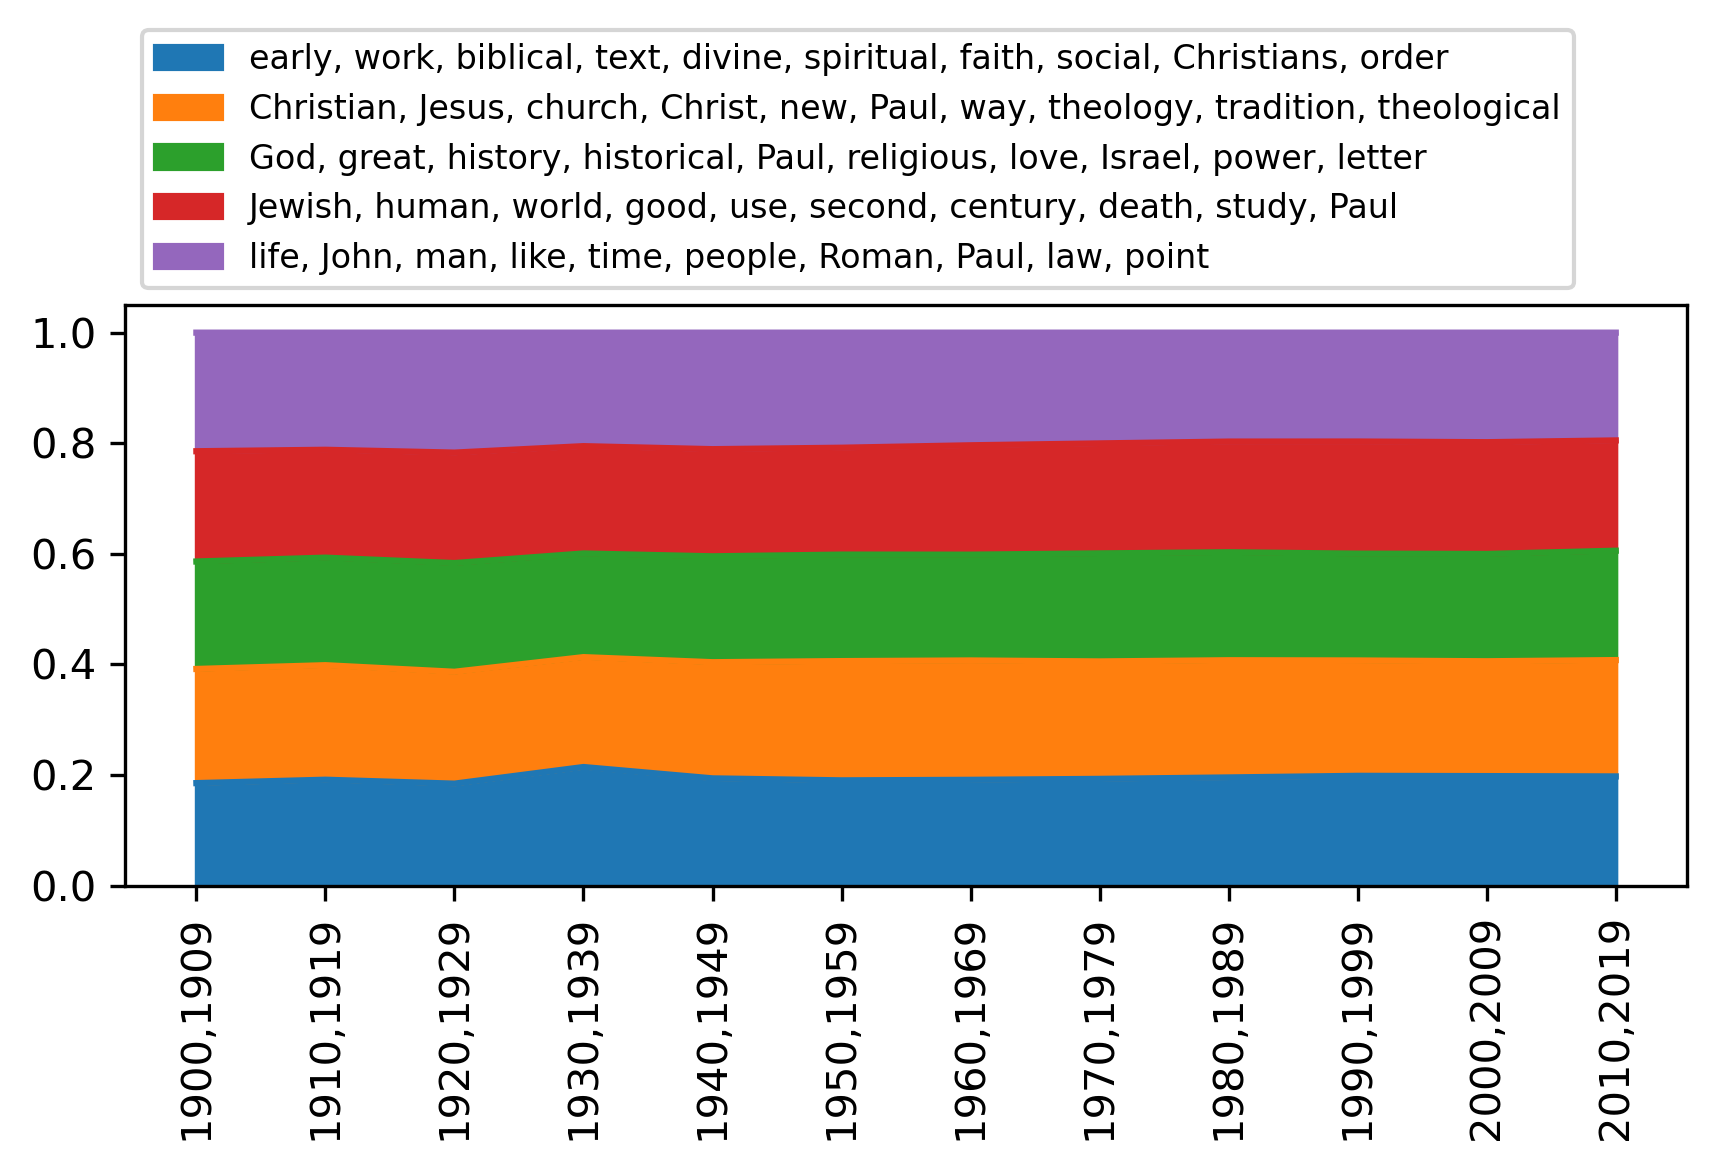

In [115]:
fig, ax = plt.subplots(1,1, tight_layout=True, dpi=300)
decades_means_df[topic_words_joined].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(0,1), loc="lower left", fontsize=8)
ax.set_xticks(range(len(decades)))
ax.set_xticklabels(decades, rotation=90)

In [116]:
fig.savefig("../figures/topics5_decades.png")